<a href="https://colab.research.google.com/github/chaitrika31/AI-MV/blob/main/Week3_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# install pyspark
!pip3 install pyspark

In [15]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, mean, when, isnull

# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
#initialize SparkSession and installed Required Libraries
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator



In [17]:
# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("LinearRegression_spark") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "3g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()

In [18]:
spark

In [19]:
print(f"Spark UI available at: {spark.sparkContext.uiWebUrl}")

Spark UI available at: http://2012517e696b:4040


In [20]:
spark.sparkContext.setLogLevel("INFO")
import psutil
print(f"CPU Usage: {psutil.cpu_percent()}%")
print(f"Memory Usage: {psutil.virtual_memory().percent}%")

CPU Usage: 19.8%
Memory Usage: 12.6%


In [21]:
data = spark.read.csv("/content/drive/MyDrive/property (1).csv", header=True, inferSchema=True)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
data.show()

+--------------+------------+-------------+----------+--------+------------------+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|             Price|
+--------------+------------+-------------+----------+--------+------------------+
|          1360|           2|            3|      1953|    7860| 303948.1373854071|
|          4272|           3|            3|      1997|    5292| 860386.2685075302|
|          3592|           4|            1|      1983|    9723| 734389.7538956215|
|           966|           6|            1|      1903|    4086| 226448.8070714377|
|          4926|           6|            4|      1944|    1081|1022486.2616704078|
|          3944|           6|            2|      1938|    3542| 845638.1354384426|
|          3671|           2|            1|      1963|    5105| 748779.2192281872|
|          3419|           4|            2|      1925|    5448| 743007.2614135538|
|           630|           2|            2|      2012|    3204| 135656.4528785377|
|   

In [24]:
# more info
print("Total Records",data.count())
print("Total Partitions ",data.rdd.getNumPartitions())

Total Records 1000000
Total Partitions  2


In [25]:
# show Schema,Prints the structure of the dataset
data.printSchema()

root
 |-- Square_Footage: integer (nullable = true)
 |-- Num_Bedrooms: integer (nullable = true)
 |-- Num_Bathrooms: integer (nullable = true)
 |-- Year_Built: integer (nullable = true)
 |-- Lot_Size: integer (nullable = true)
 |-- Price: double (nullable = true)



In [26]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 99.0%
Memory Usage after csv file: 15.4%


In [27]:
# check missing or null values for each column
from pyspark.sql.functions import col,isnan, when, count
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+--------------+------------+-------------+----------+--------+-----+
|Square_Footage|Num_Bedrooms|Num_Bathrooms|Year_Built|Lot_Size|Price|
+--------------+------------+-------------+----------+--------+-----+
|             0|           0|            0|         0|       0|    0|
+--------------+------------+-------------+----------+--------+-----+



In [28]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ["Square_Footage", "Lot_Size", "Num_Bathrooms","Year_Built","Num_Bedrooms"],
                           outputCol = "Features",)

In [29]:
#StandardScaler
scaler = StandardScaler(inputCol = "Features",
                        outputCol = "scaled_Features")
#create linear regression model.
regressor = LinearRegression(labelCol = 'Price',
                             featuresCol = 'scaled_Features'
                             )

In [30]:
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 100.0%
Memory Usage after csv file: 15.8%


In [31]:
from pyspark.ml import Pipeline
pipeline  = Pipeline(stages = [assembler,scaler,regressor])
#--Saving the Pipeline
pipeline.write().overwrite().save("pipeline_LRsaved_model")
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 99.7%
Memory Usage after csv file: 15.8%


In [32]:
#Loading the Pipeline
pipelineModel = Pipeline.load('./pipeline_LRsaved_model')

In [33]:
data_train, data_test = data.randomSplit([0.8,0.2], seed = 42)

In [34]:
Model = pipeline.fit(data_train)
print(f"CPU Usage after openig the csv file: {psutil.cpu_percent()}%")
print(f"Memory Usage after csv file: {psutil.virtual_memory().percent}%")

CPU Usage after openig the csv file: 98.2%
Memory Usage after csv file: 17.9%


In [35]:
print("total LR cofficents",len(Model.stages[2].coefficients) )
print("Cofficientents",Model.stages[2].coefficients)
print("Intecept",Model.stages[2].intercept)

total LR cofficents 5
Cofficientents [259780.12595993155,271.5939763714586,3383.347658405624,-3505.631769314011,8525.619659292961]
Intecept 201303.7713571679


In [36]:
#n the prediction phase, we test our model on some unseen data.
pred = Model.transform(data_test)
pred.select('prediction', 'Price').show(10, truncate = False)

+------------------+------------------+
|prediction        |Price             |
+------------------+------------------+
|118059.13922566958|117632.63219959654|
|109776.33782739907|106670.25438504865|
|122744.64022798225|129488.84657892359|
|114407.05613098743|115218.14440379351|
|124296.11676456698|103211.80851419755|
|121766.15789056706|95443.54011673816 |
|114882.94170203069|75029.23686169085 |
|123959.45591767559|102503.11714851807|
|127377.38339111669|146356.05433151638|
|127104.052736321  |121454.94973331907|
+------------------+------------------+
only showing top 10 rows



In [37]:
#create linear regression model.
Lasoregressor = LinearRegression(labelCol = 'Price',
                             featuresCol = 'scaled_Features',
                             elasticNetParam=1,
                             regParam=0.1
                             )
Lasaopipeline  = Pipeline(stages = [assembler,scaler,Lasoregressor])
LassoModel = Lasaopipeline.fit(data_train)

In [38]:
#create linear regression model.
Ridgeregressor = LinearRegression(labelCol = 'Price',
                             featuresCol = 'scaled_Features',
                             elasticNetParam=0,
                             regParam=0.1
                             )
Ridgepipeline  = Pipeline(stages = [assembler,scaler,Ridgeregressor])
RidgeModel = Ridgepipeline.fit(data_train)

In [39]:
#n the prediction phase, we test our model on some unseen data.
lassopred = LassoModel.transform(data_test)
lassopred.select('prediction', 'Price').show(15, truncate = False)

+------------------+------------------+
|prediction        |Price             |
+------------------+------------------+
|118059.58503624618|117632.63219959654|
|109776.99243337651|106670.25438504865|
|122744.99443028081|129488.84657892359|
|114407.64949485273|115218.14440379351|
|124296.42762001032|103211.80851419755|
|121766.34207738584|95443.54011673816 |
|114883.52882599973|75029.23686169085 |
|123959.59712819383|102503.11714851807|
|127377.56118724318|146356.05433151638|
|127104.2971532674 |121454.94973331907|
|126604.88550848867|126447.31968235047|
|127409.919708304  |117989.49702654009|
|125182.84739563154|107151.56008245455|
|128487.65707231688|124488.1412983082 |
|135449.50066814508|136802.2644219193 |
+------------------+------------------+
only showing top 15 rows



In [40]:
#n the prediction phase, we test our model on some unseen data.
Ridgepred = RidgeModel.transform(data_test)
Ridgepred.select('prediction', 'Price').show(10, truncate = False)

+------------------+------------------+
|prediction        |Price             |
+------------------+------------------+
|118059.31639102088|117632.63219959654|
|109776.51827559841|106670.25438504865|
|122744.81564146161|129488.84657892359|
|114407.23494730127|115218.14440379351|
|124296.29193350823|103211.80851419755|
|121766.33438788216|95443.54011673816 |
|114883.12028636347|75029.23686169085 |
|123959.63186982217|102503.11714851807|
|127377.55782484837|146356.05433151638|
|127104.22711147154|121454.94973331907|
+------------------+------------------+
only showing top 10 rows



In [41]:
#Model Evaluation Spark Provides evaluation metrics
#for regression and classification tasks.
from pyspark.ml.evaluation import RegressionEvaluator
evaluator_mean_Square_Error = RegressionEvaluator(labelCol =
                                    'Price',
                                    predictionCol =
                                    'prediction',
                                    metricName =
                                    'mse')

In [42]:
# calculate MSE
mse1 = evaluator_mean_Square_Error.evaluate(pred)
mselasso = evaluator_mean_Square_Error.evaluate(lassopred)
mseridge = evaluator_mean_Square_Error.evaluate(Ridgepred)

evaluator_rmse = RegressionEvaluator(labelCol =
                                     'Price',
                                     predictionCol =
                                     'prediction',
                                     metricName =
                                     'rmse')

In [43]:
# calculate RMSE
rmse1 = evaluator_rmse.evaluate(pred)
rmse2_lasso = evaluator_rmse.evaluate(lassopred)
rmse3Ridge = evaluator_rmse.evaluate(Ridgepred)

evaluator_r2 = RegressionEvaluator(labelCol = 'Price',
                                   predictionCol = 'prediction',
                                   metricName = 'r2')

In [44]:
# calculate R_squared
r2_score1 = evaluator_r2.evaluate(pred)
r2_lasso = evaluator_r2.evaluate(lassopred)
r2_ridge = evaluator_r2.evaluate(Ridgepred)
# print the evaluation metrics
print('Regression - MSE: ', mse1, ', RMSE: ', rmse1, ', R^2: ', r2_score1)
print('Lasso - MSE: ', mselasso, ', RMSE: ', rmse2_lasso, ', R^2: ', r2_lasso)
print('Ridge - MSE: ', mseridge, ', RMSE: ', rmse3Ridge, ', R^2: ', r2_ridge)

Regression - MSE:  400269383.42082375 , RMSE:  20006.733452036187 , R^2:  0.9940979930679151
Lasso - MSE:  400269386.8777617 , RMSE:  20006.733538430548 , R^2:  0.9940979930169423
Ridge - MSE:  400269386.33788484 , RMSE:  20006.73352493817 , R^2:  0.9940979930249029


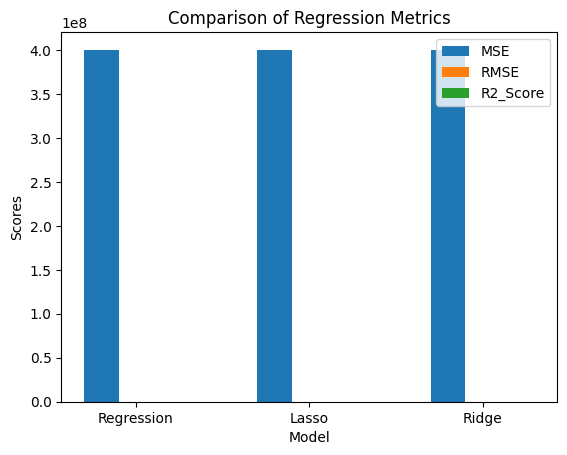

In [45]:
# plot
import matplotlib.pyplot as plt
import numpy as np

mse = [mse1, mselasso, mseridge]
rmse = [rmse1, rmse2_lasso, rmse3Ridge]
r2_score = [r2_score1, rmse2_lasso, r2_ridge]

positions = np.arange(len(mse))
bar_width = 0.2

plt.bar(positions - bar_width, mse, width = bar_width, label = 'MSE')
plt.bar(positions, rmse, width = bar_width, label = 'RMSE')
plt.bar(positions + bar_width, r2_score, width = bar_width, label = 'R2_Score')

# adding labels and title
plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Comparison of Regression Metrics')

# adding the legend
plt.legend()
plt.xticks(positions, ['Regression', 'Lasso', 'Ridge'])
plt.show()